In [25]:
import os

In [26]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'preprocessing/generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [27]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [28]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [29]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [30]:
import object_detection
import wget

In [31]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

100% [........................................................................] 20515344 / 20515344        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


In [32]:
labels = [{'name':'licence', 'id':1}] # Data spells license as licence

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [33]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


In [34]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


In [35]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [36]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [37]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [38]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [39]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [40]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

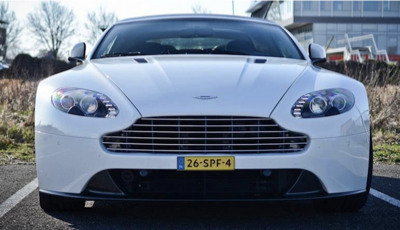

In [41]:
import PIL
train = "./Tensorflow/workspace/images/train"

PIL.Image.open(train + '/cars222.png')

In [42]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [43]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [44]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=10000


In [45]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [46]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


In [23]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [24]:
#prevent gpu complete consumption
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [9]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [8]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])


In [10]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars420.png')

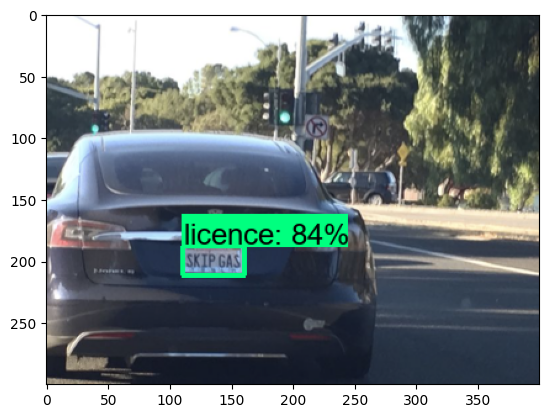

In [11]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.6,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
import easyocr

In [13]:
detection_threshold = 0.6

In [14]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [15]:
image

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 45,  40,  33],
        [ 46,  41,  34],
        [ 48,  43,  36]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 45,  40,  33],
        [ 45,  41,  34],
        [ 47,  43,  36]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 46,  41,  34],
        [ 46,  41,  34],
        [ 47,  42,  35]],

       ...,

       [[134, 152, 161],
        [130, 147, 157],
        [112, 129, 138],
        ...,
        [ 68,  51,  40],
        [ 67,  51,  40],
        [ 68,  52,  41]],

       [[148, 165, 174],
        [138, 155, 164],
        [119, 135, 145],
        ...,
        [ 69,  52,  41],
        [ 68,  51,  40],
        [ 67,  51,  40]],

       [[123, 140, 149],
        [122, 139, 148],
        [120, 137, 146],
        ...,
        [ 69,  53,  42],
        [ 69,  52,  42],
        [ 67,  51,  40]]

In [16]:
width = image.shape[1]
height = image.shape[0]
print('w:', width, '\nh:', height)


w: 400 
h: 300


[0.62867934 0.2759096  0.70474035 0.40259123]
[188.60380054 110.36384106 211.42210364 161.03649139]
[([[3, 5], [51, 5], [51, 21], [3, 21]], 'SKIP GAS', 0.2508102876024006)]


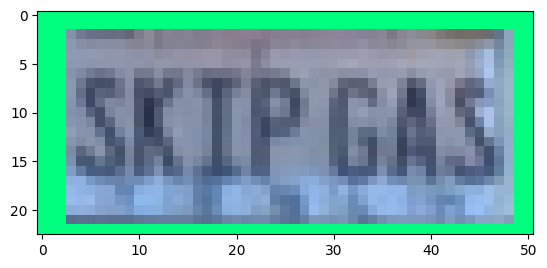

In [17]:
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [18]:
# filtering out other text to only grab main text
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

16
SKIP GAS


In [20]:
region_threshold = 0.3

In [21]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [22]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

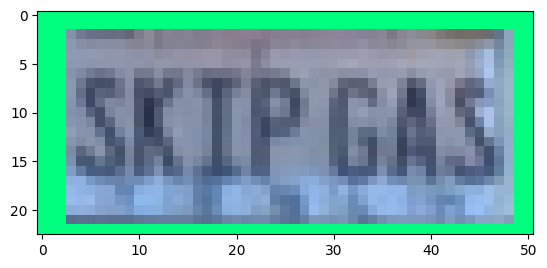

['SKIP GAS']


In [23]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
